In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
import re
from collections import Counter
import holidays
from sklearn.cluster import KMeans
from scipy import stats
from dateutil.relativedelta import relativedelta
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data = pd.read_csv(r"/Users/weizhou/Desktop/DS4A/Data/retail_cluster.csv")

# Cluster 0

In [19]:
cluster0 = data[data['cluster'] == 0]

In [20]:
sales_cluster0 = cluster0.groupby(data['InvoiceDay'])['Revenue'].sum()
sales_cluster0.index = pd.to_datetime(sales_cluster0.index)

In [21]:
sales_cluster0

InvoiceDay
2009-12-01    11606.89
2009-12-02    12787.97
2009-12-03    15447.90
2009-12-04     6881.18
2009-12-05     4288.15
                ...   
2011-12-05    14683.87
2011-12-06    13375.99
2011-12-07    15107.12
2011-12-08    13961.79
2011-12-09     3791.29
Name: Revenue, Length: 604, dtype: float64

In [24]:
# detect outliers index
def detect_outliers(data):
    # calculate z-score
    z = np.abs(stats.zscore(data))
    # find the index of outliers
    outliers = data[z>3].index
    return outliers

outliers = detect_outliers(sales_cluster0)

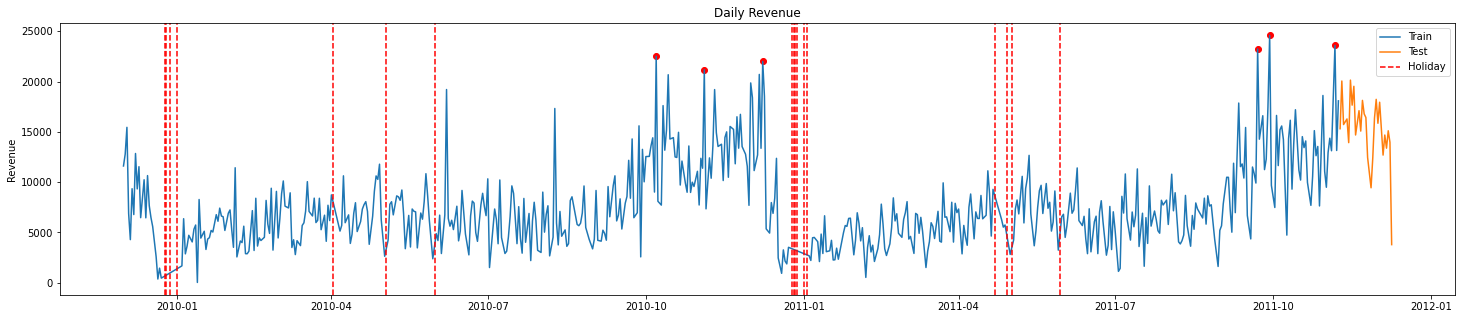

In [37]:
# split data into train and test and plot
# keep the last month data as test set
max_date = sales_cluster0.index.max().date()
train = sales_cluster0[:max_date -  relativedelta(months=1)][:-1]
test = sales_cluster0[max_date - relativedelta(months=1):]
# plot daily revenue and holidays
uk_holidays = list(holidays.GB(years=[2009, 2010, 2011, 2012]).keys())
fig = plt.figure(figsize=(25, 5))
plt.plot(train)
plt.plot(test)
[plt.axvline(i, color='red', linestyle='--') for i in uk_holidays if i >= sales_cluster0.index.min().date() and i <= sales_cluster0.index.max().date()]
# plot outliers as point
plt.scatter(outliers, sales_cluster0.loc[outliers], c='red', marker='o', label="Outliers")
plt.title('Daily Revenue')
plt.ylabel('Revenue')
plt.legend(['Train', 'Test', 'Holiday'])
plt.show()

In [38]:
# Add missing date to the data
sales_cluster0 = sales_cluster0.resample('D').sum()
train_cluster0 = sales_cluster0[:max_date -  relativedelta(months=1)][:-1]
test_cluster0 = sales_cluster0[max_date - relativedelta(months=1):]

## ARIMA

In [40]:
#check stationarity
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

### ACF and PACF plots

In [41]:
def acf_pacf_plot(data):
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    plot_acf(data, ax=ax[0], lags=60)
    plot_pacf(data, ax=ax[1], lags=60)
    plt.show()


In [42]:
def predict(stepwise_model, train, test):
    stepwise_model.fit(train)
    # check whether overfit
    forecast_train = stepwise_model.predict_in_sample()
    forecast_train = pd.DataFrame(forecast_train)
    forecast_train.index = train.index
    forecast_train.columns = ['Predict']

    forecast_test = stepwise_model.predict(n_periods=len(test))
    forecast_test = pd.DataFrame(forecast_test)
    forecast_test.index = test.index
    forecast_test.columns = ['Predict']

    forecast = pd.concat([forecast_train, forecast_test])

    return forecast, forecast_train, forecast_test

In [43]:
# calculate the MAPE, MAE, RMSE for training and test set
def calculate_error(test, forecast):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    # when test is 0, skip it for mape
    test_mape = test[test != 0]
    forecast_mape = forecast[test != 0]
    mape = np.mean(np.abs(test_mape - forecast_mape)/np.abs(test_mape))

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

In [44]:
# plot the error
def plot_error(train, test, forecast, mape_test, mae_test, rmse_test, order, seasonal_order):
    plt.figure(figsize=(25,5))  
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(forecast, label='Prediction')
    # plot outliers as point
    plt.scatter(outliers, pd.concat([train, test]).loc[outliers], c='red', marker='o', label="Outliers")
    plt.legend(loc='upper left')
    plt.title('{}{} - MAPE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(order, seasonal_order, mape_test, mae_test, rmse_test))
    plt.show()

ADF Statistic: -1.921998
p-value: 0.321784
Non-Stationary
ADF Statistic: -7.457622
p-value: 0.000000
Stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


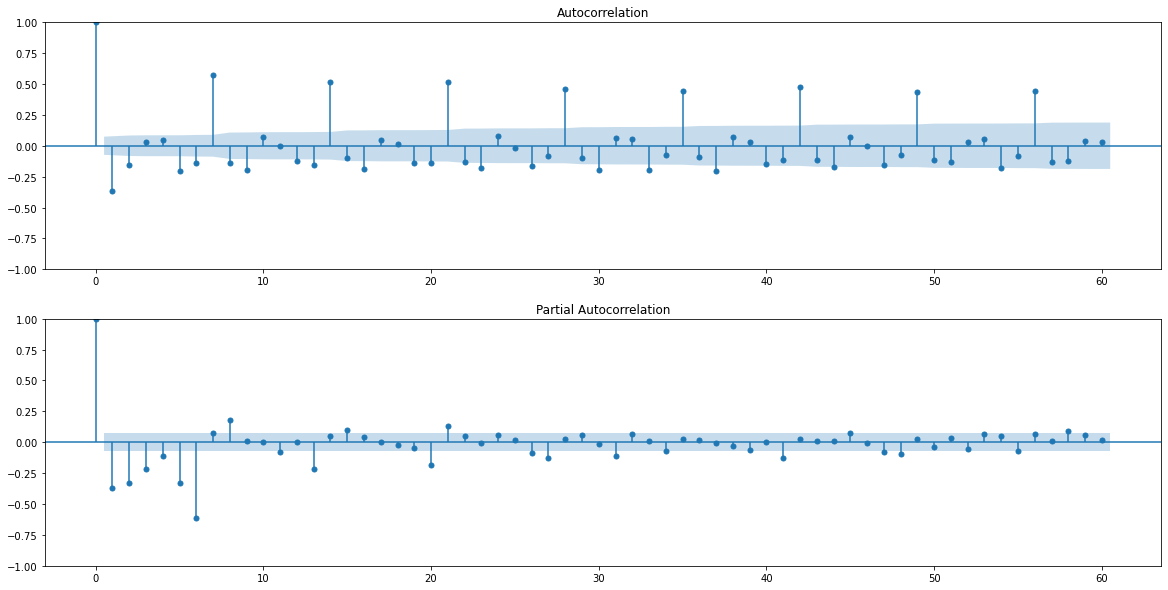

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14095.329, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13601.662, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13598.343, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14093.332, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13781.445, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=13397.302, Time=1.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=13482.141, Time=0.35 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=13464.325, Time=1.91 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13543.227, Time=1.57 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=13428.653, Time=0.78 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=13647.521, Time=0.76 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   :

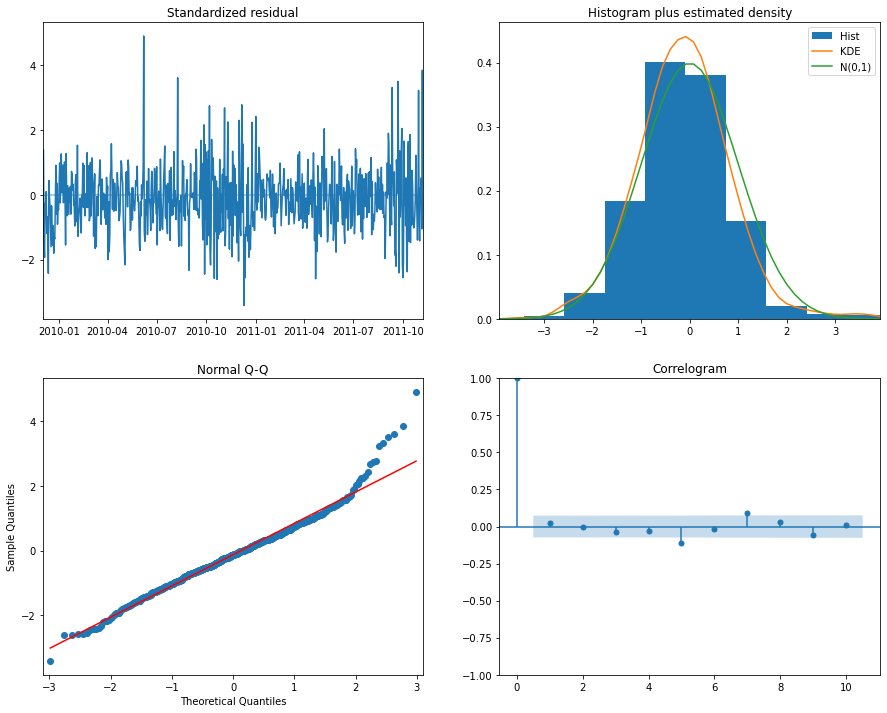

            Train         Test
MAPE     0.688658     0.486601
MAE   2336.191510  5501.290166
RMSE  3091.532710  7037.298664
(0, 1, 2) (1, 0, 1, 7)


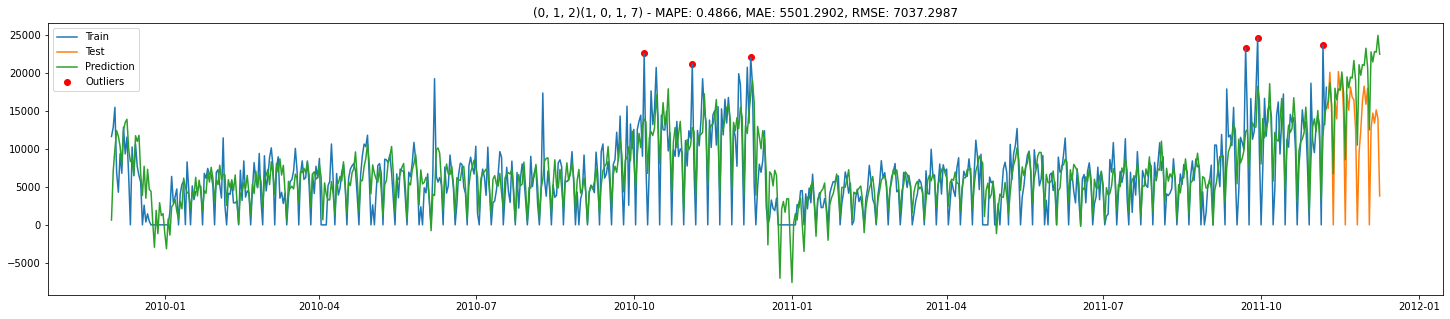

In [45]:
check_stationarity(train_cluster0)
check_stationarity(train_cluster0.diff().dropna())
acf_pacf_plot(train_cluster0.diff().dropna())

stepwise_model = auto_arima(train_cluster0, m=7, trace=True, suppress_warnings=True, stepwise=True)
stepwise_model.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, forecast_train, forecast_test = predict(stepwise_model, train_cluster0, test_cluster0)

mape_train, mae_train, rmse_train = calculate_error(train_cluster0, forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test_cluster0, forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

print(stepwise_model.order, stepwise_model.seasonal_order)
plot_error(train_cluster0, test_cluster0, forecast, mape_test, mae_test, rmse_test, stepwise_model.order, stepwise_model.seasonal_order)

# ARIMAX

In [56]:
# add holidays and Saturday as exogenous variables
sales_cluster0 = pd.DataFrame(sales_cluster0)
# 1 if it is a holiday, else 0
sales_cluster0['Holiday'] = sales_cluster0.index.map(lambda x: 1 if x.date() in uk_holidays else 0)
# 1 if it is a Saturday, else 0
sales_cluster0['Saturday'] = sales_cluster0.index.map(lambda x: 1 if x.weekday() == 5 else 0)

In [57]:
# split 
train_cluster0 = sales_cluster0[:max_date -  relativedelta(months=1)][:-1]
test_cluster0 = sales_cluster0[max_date - relativedelta(months=1):]

In [58]:
def predict_ARIMAX(train, test, exogenous):
    stepwise_model.fit(train['Revenue'], train[exogenous])
    # check whether overfit
    forecast_train = stepwise_model.predict_in_sample(X=train[exogenous])
    forecast_train = pd.DataFrame(forecast_train)
    forecast_train.index = train.index
    forecast_train.columns = ['Predict']

    forecast_test = stepwise_model.predict(n_periods=len(test), X=test[exogenous])
    forecast_test = pd.DataFrame(forecast_test)
    forecast_test.index = test.index
    forecast_test.columns = ['Predict']

    forecast = pd.concat([forecast_train, forecast_test])

    return forecast, forecast_train, forecast_test

ADF Statistic: -1.921998
p-value: 0.321784
Non-Stationary
ADF Statistic: -7.457622
p-value: 0.000000
Stationary


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


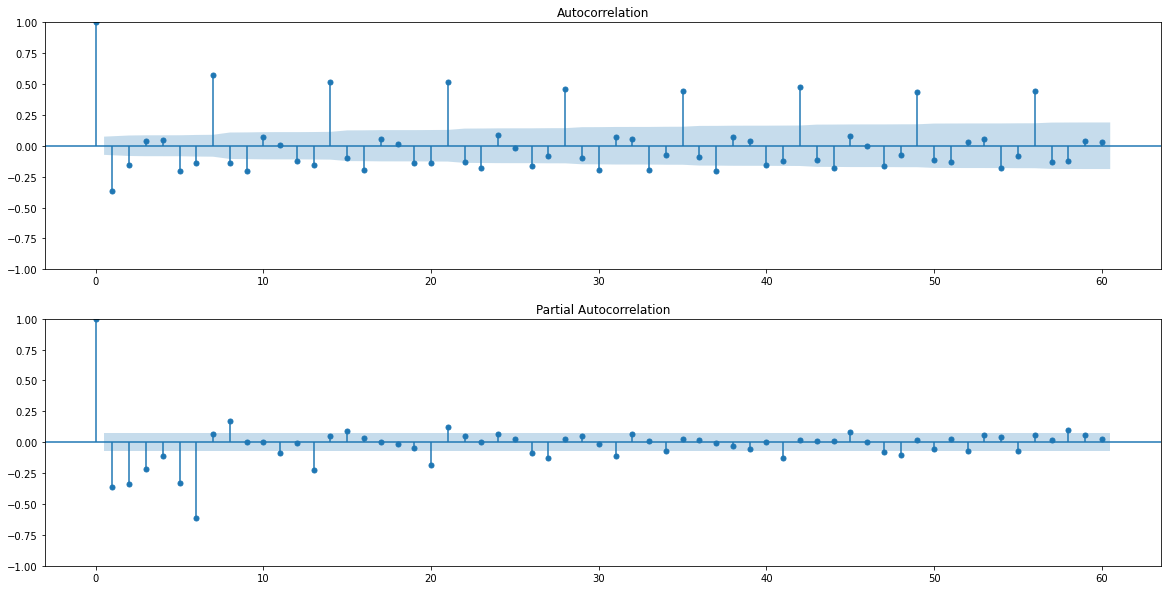

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=13301.516, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13713.745, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13454.546, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13335.155, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17644.398, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=13329.092, Time=0.85 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=13312.578, Time=0.74 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=13294.530, Time=2.46 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=13310.211, Time=1.14 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=13297.305, Time=2.45 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=13294.994, Time=2.70 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=13311.553, Time=2.47 sec
 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=13295.593, Time=2.84 sec
 ARIMA(2,1,3)(2,0,1)[7] i

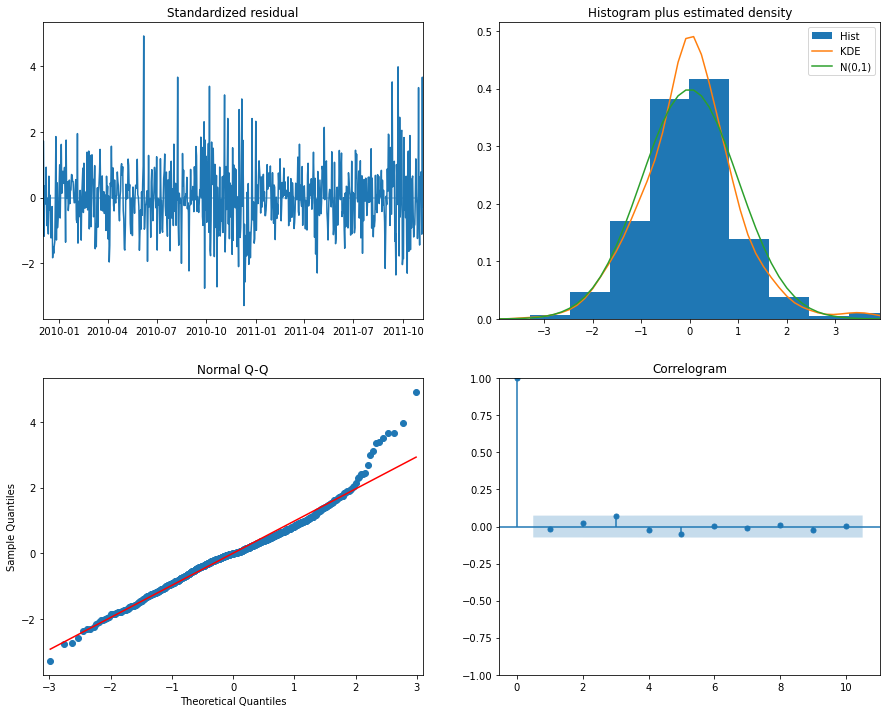

            Train         Test
MAPE     0.633121     0.256809
MAE   2139.089249  2951.086812
RMSE  2918.207129  3946.802947
(2, 1, 2) (2, 0, 1, 7)


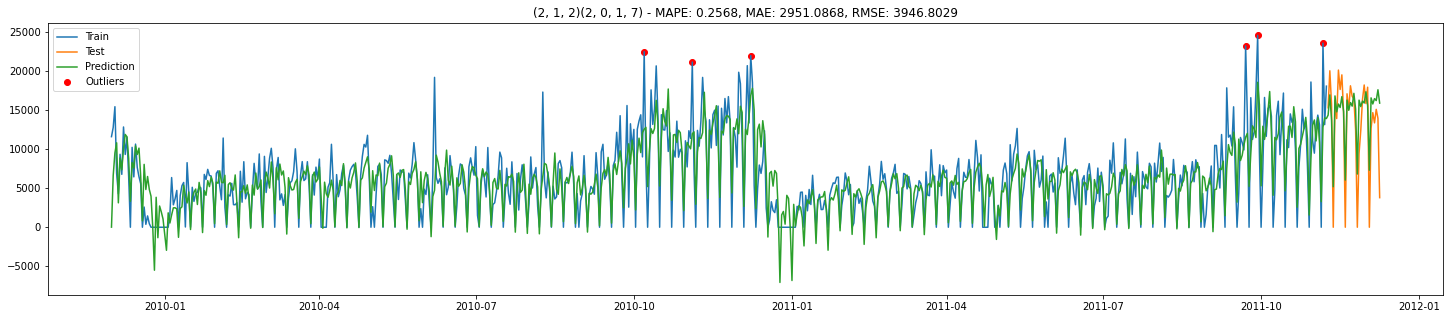

In [60]:
# same as ARIMA
check_stationarity(train_cluster0['Revenue'])
check_stationarity(train_cluster0['Revenue'].diff().dropna())
acf_pacf_plot(train['Revenue'].diff().dropna())

stepwise_model = auto_arima(train_cluster0['Revenue'], X=train_cluster0[['Holiday', 'Saturday']], m=7, trace=True, suppress_warnings=True, stepwise=True, test='adf')
stepwise_model.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast, forecast_train, forecast_test = predict_ARIMAX(train_cluster0, test_cluster0, ['Holiday', 'Saturday'])

mape_train, mae_train, rmse_train = calculate_error(train_cluster0['Revenue'], forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test_cluster0['Revenue'], forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

print(stepwise_model.order, stepwise_model.seasonal_order)
plot_error(train_cluster0['Revenue'], test_cluster0['Revenue'], forecast, mape_test, mae_test, rmse_test, stepwise_model.order, stepwise_model.seasonal_order)

# Holt Winters

In [62]:
# remove negative sales in order to use mupltiplicative model
# add minimum negative sales to all sales
pos_sales_cluster0 = sales_cluster0.copy()
min_sales_cluster0 = sales_cluster0['Revenue'].min() - 0.01
pos_sales_cluster0['Revenue'] = pos_sales_cluster0['Revenue'] + np.abs(min_sales_cluster0)


In [67]:
# split
pos_train_cluster0 = pos_sales_cluster0[:max_date -  relativedelta(months=1)][:-1]['Revenue']
pos_test_cluster0 = pos_sales_cluster0[max_date - relativedelta(months=1):]['Revenue']

In [69]:
# ETS models
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import itertools

# Define a list of hyperparameters to search through
error = ['add', 'mul']
trend = ['add', 'additive', 'mul', None]
seasonal = ['add', 'additive', 'mul', None]
seasonal_periods = [7]  # Modify this based on your data's seasonality
param_grid = list(itertools.product(error, trend, seasonal, seasonal_periods))

best_aic = float("inf")
for param in param_grid:
    try:
        if param[2] == None: # seasonal is None
            model = ETSModel(pos_train_cluster0, error=param[0], trend=param[1])
        else:
            model = ETSModel(pos_train_cluster0, error=param[0], trend=param[1], seasonal=param[2], seasonal_periods=param[3])
        results = model.fit(disp=0)
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_error = param[0]
            best_trend = param[1]
            best_seasonal = param[2]
            best_model = results
    except:
        print('wrong parameters:', param)
        continue

# print the best model
print(best_model.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1161: RuntimeWarning: overflow encountered in square
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1161: RuntimeWarning: overflow encountered in square
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1161: RuntimeWarning: overflow encountered in square
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=wher

                                 ETS Results                                  
Dep. Variable:                Revenue   No. Observations:                  708
Model:                       ETS(MNM)   Log Likelihood               -5565.908
Date:                Sat, 28 Oct 2023   AIC                          11153.816
Time:                        19:56:21   BIC                          11204.003
Sample:                    12-01-2009   HQIC                         11173.206
                         - 11-08-2011   Scale                            0.388
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0001   8.08e-05      1.237      0.216   -5.84e-05       0.000
smoothing_seasonal     0.5150      0.004    129.613      0.000       0.507       0.523
initial_level       

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


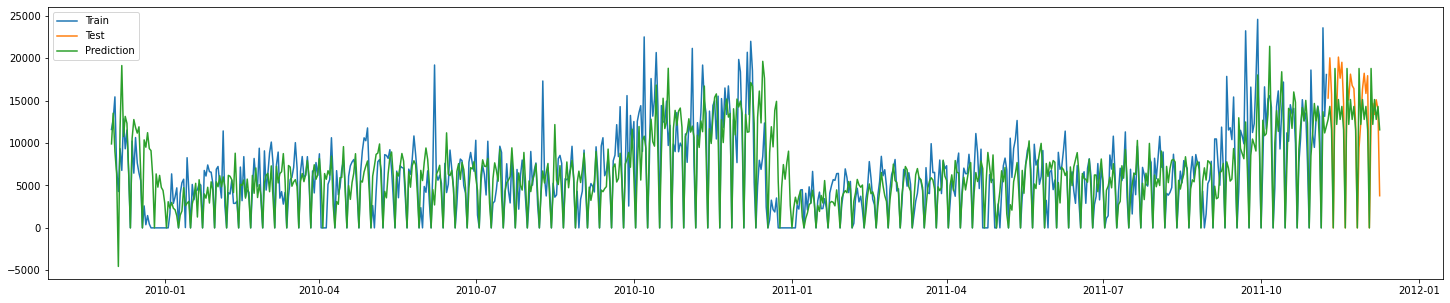

In [71]:
# predict
forecast_train = best_model.predict(start=pos_train_cluster0.index[0], end=pos_train_cluster0.index[-1])
forecast_train = pd.DataFrame(forecast_train - np.abs(min_sales_cluster0), columns=['Predict'])

forecast_test = best_model.predict(start=pos_test_cluster0.index[0], end=pos_test_cluster0.index[-1])
forecast_test = pd.DataFrame(forecast_test - np.abs(min_sales_cluster0), columns=['Predict'])

forecast = pd.concat([forecast_train, forecast_test])

# plot the predictions for test set
plt.figure(figsize=(25,5))
plt.plot(train_cluster0['Revenue'], label='Train')
plt.plot(test_cluster0['Revenue'], label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='upper left')
plt.show()


In [72]:
# calculate the MAPE, MAE, RMSE for training and test set
mape_train, mae_train, rmse_train = calculate_error(train_cluster0['Revenue'], forecast_train['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test_cluster0['Revenue'], forecast_test['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

            Train         Test
MAPE     0.659669     0.286362
MAE   2365.384662  3042.596075
RMSE  3406.462901  3880.538289


In [73]:
print(best_aic, best_error, best_trend, best_seasonal)

11153.816235918815 mul None mul


# FB-Prophet

In [74]:
m = Prophet()
m.add_country_holidays(country_name='GB')
# future = m.make_future_dataframe(periods=len(test))
forecast = m.fit(train_cluster0.reset_index().rename(columns={'InvoiceDay':'ds', 'Revenue':'y'})).predict(m.make_future_dataframe(periods=len(test_cluster0)))

20:00:59 - cmdstanpy - INFO - Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1] done processing


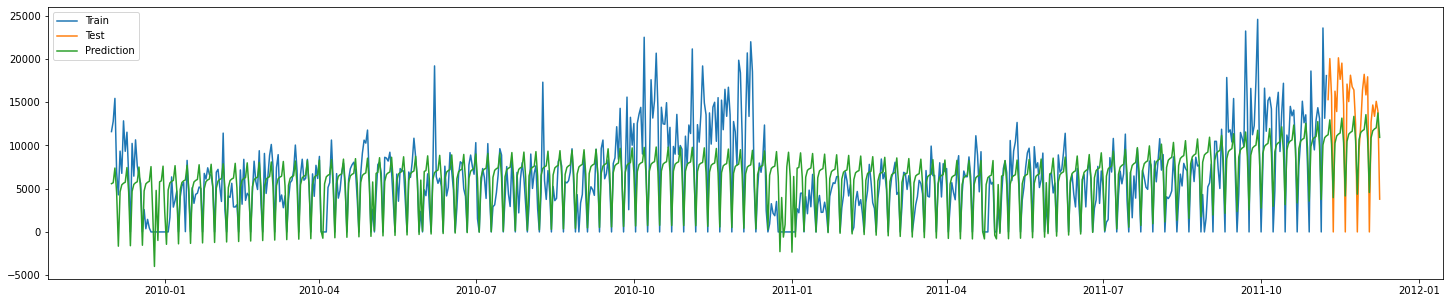

In [75]:
#plot
plt.figure(figsize=(25,5))
plt.plot(train_cluster0['Revenue'], label='Train')
plt.plot(test_cluster0['Revenue'], label='Test')
plt.plot(pd.DataFrame(forecast['yhat'].values, index=forecast['ds']), label='Prediction')
plt.legend(loc='upper left')
plt.show()


In [76]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [77]:
plot_components_plotly(m, forecast)

In [79]:
mape_train, mae_train, rmse_train = calculate_error(train_cluster0['Revenue'], pd.DataFrame(forecast[forecast['ds'].isin(train_cluster0.index)]['yhat'].values, index=train_cluster0.index, columns=['Predict'])['Predict'])
mape_test, mae_test, rmse_test = calculate_error(test_cluster0['Revenue'], pd.DataFrame(forecast[forecast['ds'].isin(test_cluster0.index)]['yhat'].values, index=test_cluster0.index, columns=['Predict'])['Predict'])
metrics = pd.DataFrame({'Train':[mape_train, mae_train, rmse_train], 'Test':[mape_test, mae_test, rmse_test]}, index=['MAPE', 'MAE', 'RMSE'])
print(metrics)

            Train         Test
MAPE     0.840102     0.316495
MAE   2461.518560  4348.507158
RMSE  3429.316633  4848.656956


# LSTM

In [80]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [113]:
min_max_scaler = MinMaxScaler()
scaler_train = min_max_scaler.fit_transform(train_cluster0['Revenue'].values.reshape(-1,1))
scaler_test = min_max_scaler.transform(test_cluster0['Revenue'].values.reshape(-1,1))

# LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_train, y_train = create_dataset(scaler_train, scaler_train, time_steps)
X_test, y_test = create_dataset(scaler_test, scaler_test, time_steps)

model = Sequential()
model.add(LSTM(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
# , return_sequences=True
# model.add(LSTM(units=4, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, shuffle=False)

test_predictions = []
first_eval_batch = scaler_train[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, 1))

for i in range(len(test_cluster0)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_test_predictions = min_max_scaler.inverse_transform(test_predictions)
test_cluster0['Predictions'] = true_test_predictions

# train_predictions = []
# first_eval_batch = scaler_train[:time_steps]
# current_batch = first_eval_batch.reshape((1, time_steps, 1))

# for i in range(len(train)-time_steps):
#     # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#     current_pred = model.predict(current_batch)[0]
    
#     # store prediction
#     train_predictions.append(current_pred) 
    
#     # update batch to now include prediction and drop first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# true_train_predictions = min_max_scaler.inverse_transform(train_predictions)
# train['Predictions'] = np.append(np.array([np.NaN] * time_steps).reshape(time_steps, 1), true_train_predictions)

Epoch 1/100
44/44 [==============================] - 1s 1ms/step - loss: 0.0414
Epoch 2/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 5/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0270
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 9/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 10/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 11/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 12/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0257
Epoch 13/100
44/44 [=================

/var/folders/vz/pjwcblyj0519y8k2hl3dhmrw0000gn/T/ipykernel_5764/1552063402.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



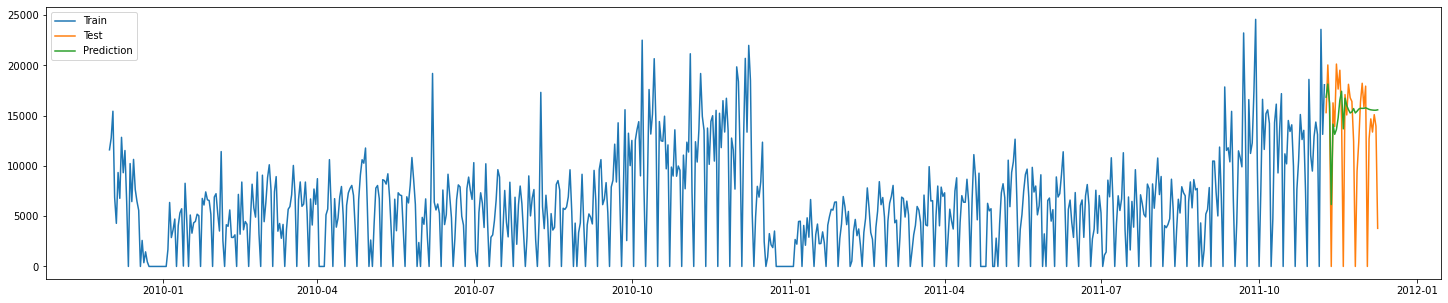

In [114]:
# plot the predictions for test set
plt.figure(figsize=(25,5))
plt.plot(train_cluster0['Revenue'], label='Train')
plt.plot(test_cluster0['Revenue'], label='Test')
plt.plot(test_cluster0['Predictions'], label='Prediction')
# plt.plot(train['Predictions'], label='Prediction_1')
plt.legend(loc='upper left')
plt.show()


In [115]:
rmse_lstm = np.sqrt(mean_squared_error(test_cluster0['Revenue'], test_cluster0['Predictions']))
mape_lstm = np.mean(np.abs(test_cluster0[test_cluster0['Revenue']!=0]['Revenue'] - test_cluster0[test_cluster0['Revenue']!=0]['Predictions'])/np.abs(test_cluster0[test_cluster0['Revenue']!=0]['Revenue']))
mae_lstm = mean_absolute_error(test_cluster0['Revenue'], test_cluster0['Predictions'])
print('RMSE: {:.4f}, MAPE: {:.4f}, MAE: {:.4f}'.format(rmse_lstm, mape_lstm, mae_lstm))

RMSE: 5734.2933, MAPE: 0.2515, MAE: 3772.1854


In [ ]:
RMSE: 5093.7869, MAPE: 0.2346, MAE: 3570.0223 # 8 units, 1 layer